In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

### data pre-precess

In [6]:
# Load the training data
train_data = pd.read_csv("data/train_transformed.csv")
# Load the evaluation data
eval_data = pd.read_csv("data/evaluation_transformed.csv")

In [7]:
train_data.head()

,id,user_verified,user_statuses_count,user_followers_count,user_friends_count,ratio_friends_followers,mention_exist,mention_count,url_exist,url_count,...,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,tf_idf_8,tf_idf_9
0,0,0,68460,1101,1226,1.112523,0,0,0,0,...,-1.606137e-15,-1.992248e-13,-6.077335e-13,-1.726278e-12,7.402787e-13,2.375980e-14,2.692723e-13,5.657295e-13,-2.124336e-14,9.444088e-14
1,1,0,309,51,202,3.884615,0,0,0,0,...,1.206801e-02,2.715082e-03,1.318767e-02,3.157979e-02,2.662453e-02,1.621955e-02,-2.204838e-02,9.316040e-03,3.288260e-03,7.966161e-02
2,2,0,3241,1675,2325,1.387232,0,0,0,0,...,5.095493e-02,-1.131896e-03,3.852378e-02,1.163440e-01,1.542300e-01,2.938599e-01,4.018045e-01,1.909630e-01,3.218782e-01,-4.933187e-02
3,3,0,32327,667,304,0.455090,0,0,0,0,...,8.873053e-03,1.403727e-03,3.399734e-03,1.401861e-02,9.761796e-03,9.215406e-03,6.693422e-03,8.483338e-03,-2.502589e-03,1.261141e-02
4,4,0,581,42,127,2.953488,0,0,0,0,...,2.774364e-02,-1.756079e-03,8.245230e-03,3.155745e-02,1.385880e-02,5.119571e-03,3.617241e-03,1.908667e-02,-1.212654e-02,1.883319e-02


In [19]:
print(train_data.columns.values.tolist())

['id', 'user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_exist', 'mention_count', 'url_exist', 'url_count', 'hashtag_exist', 'hashtag_count', 'timeseg', 'weekend', 'day_of_week', 'text_length', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_comp', 'retweet_count', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2', 'tf_idf_3', 'tf_idf_4', 'tf_idf_5', 'tf_idf_6', 'tf_idf_7', 'tf_idf_8', 'tf_idf_9']


In [8]:
# scsplit method is used in order to split our regression data in a stratisfied way and keep a similar distribution of retweet counts between the two sets
X_train_all, X_test_all, y_train, y_test = scsplit(train_data, train_data['retweet_count'], stratify=train_data['retweet_count'], train_size=0.7, test_size=0.3)


In [9]:
features_need_scaled=['user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_count','url_count', 'hashtag_count', 'text_length']
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_all[features_need_scaled])
X_train_all[features_need_scaled] = scaler.transform(X_train_all[features_need_scaled])
X_test_all[features_need_scaled] = scaler.transform(X_test_all[features_need_scaled])

X_train_all.head()

,id,user_verified,user_statuses_count,user_followers_count,user_friends_count,ratio_friends_followers,mention_exist,mention_count,url_exist,url_count,...,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,tf_idf_8,tf_idf_9
508500,508500,0,-0.222691,-0.094308,-0.145741,-0.179365,0,-0.231261,0,-0.674189,...,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
488729,488729,0,-0.377209,-0.094443,-0.148371,-0.139497,0,-0.231261,0,-0.674189,...,0.089479,-0.095790,0.194195,0.046856,-0.029480,-0.009717,0.001415,-0.008738,-0.001823,0.000537
226347,226347,0,-0.214917,-0.094357,-0.145039,-0.165277,0,-0.231261,0,-0.674189,...,0.175484,0.443715,0.136947,0.066713,-0.031514,-0.008390,-0.000704,-0.011908,0.005994,0.017957
403341,403341,0,-0.405142,-0.063831,-0.106169,-0.221242,0,-0.231261,1,1.367164,...,0.303091,-0.135395,0.151898,0.008382,-0.009744,0.002346,0.019172,0.017415,-0.002208,0.014552
642503,642503,1,-0.160296,0.140460,-0.098922,-0.222306,0,-0.231261,1,1.367164,...,0.402559,-0.066986,-0.120335,-0.065982,0.203941,0.720841,-0.469842,-0.107030,-0.054734,-0.067254


## Gradient Boosting Regressor

In [22]:
def gbr(features_selected):
    # Now we can train our model. Here we chose a Gradient Boosting Regressor and we set our loss function 
    X_train = X_train_all[features_selected]
    X_test = X_test_all[features_selected]
    reg = GradientBoostingRegressor()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    
    # Plot the feature importances
    index_sort = np.argsort(reg.feature_importances_)[::-1]
    plt.figure(figsize=[15,5])
    plt.plot(X_train.columns[index_sort], reg.feature_importances_[index_sort])
    plt.xticks(rotation='vertical')
    plt.xlabel('importances')
    plt.ylabel('features')
    plt.title("Feature importances with Gradient Boosting Regressor")

[0.11298258 0.53482267 0.35219475]
Prediction error: 261.2627395122109


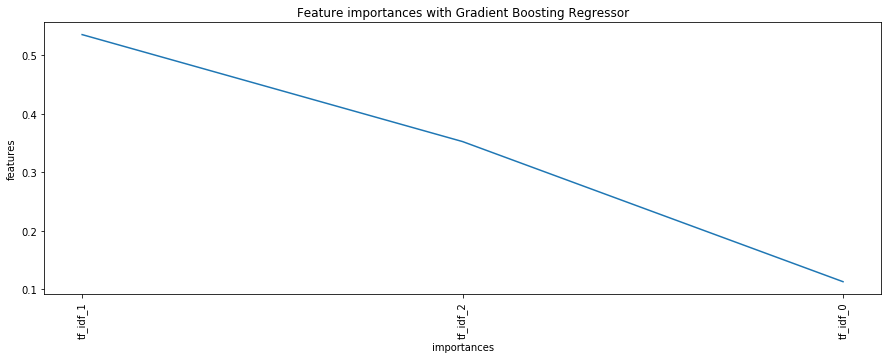

In [21]:
# features_selected = ['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_exist', 'url_exist', 'hashtag_exist',  'weekend',  'text_length', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
features_selected_base = ['tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected_base)

Prediction error: 299.1717938983355


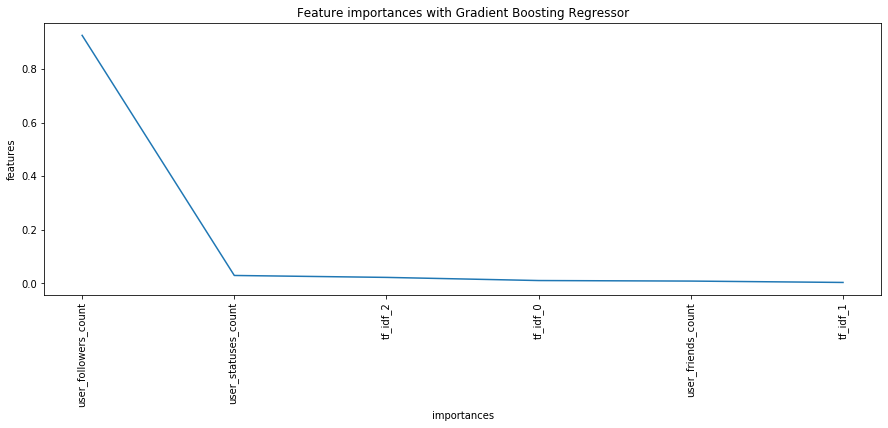

In [24]:
features_selected_count = ['user_statuses_count', 'user_followers_count', 'user_friends_count', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected_count)

Prediction error: 245.7027049294473


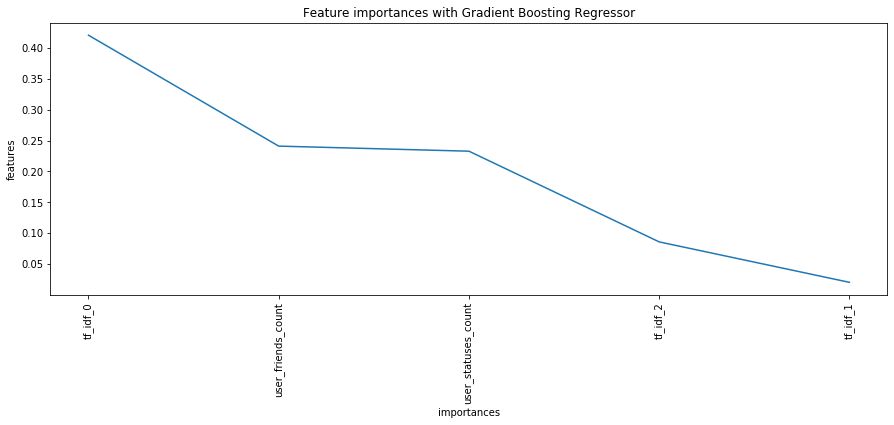

In [25]:
features_selected_count = ['user_statuses_count','user_friends_count', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected_count)

Prediction error: 257.1041242424608


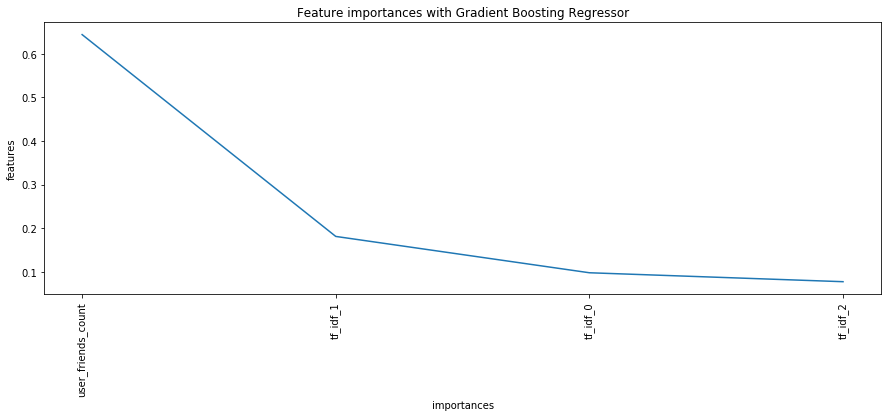

In [34]:
features_selected_count = ['user_friends_count', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected_count)

Prediction error: 185.55455273387716


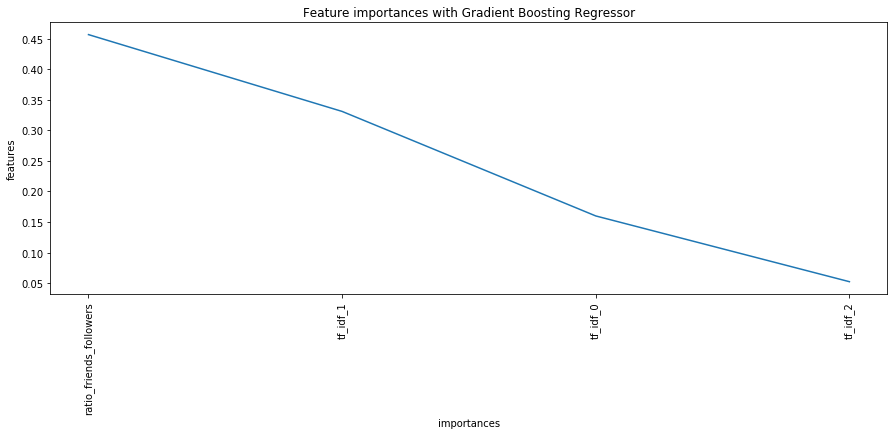

In [28]:
features_selected = ['ratio_friends_followers', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 261.66456799266393


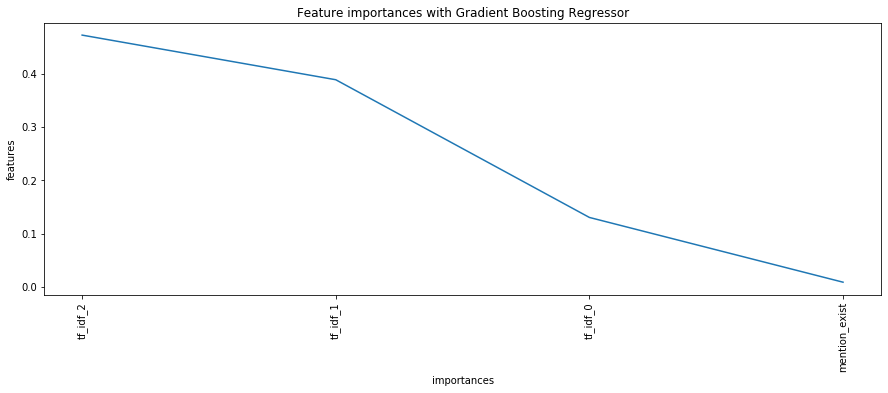

In [29]:
# features_selected = ['mention_exist', 'url_exist', 'hashtag_exist',  'weekend',  'text_length', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
features_selected = ['mention_exist', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 254.83757179469353


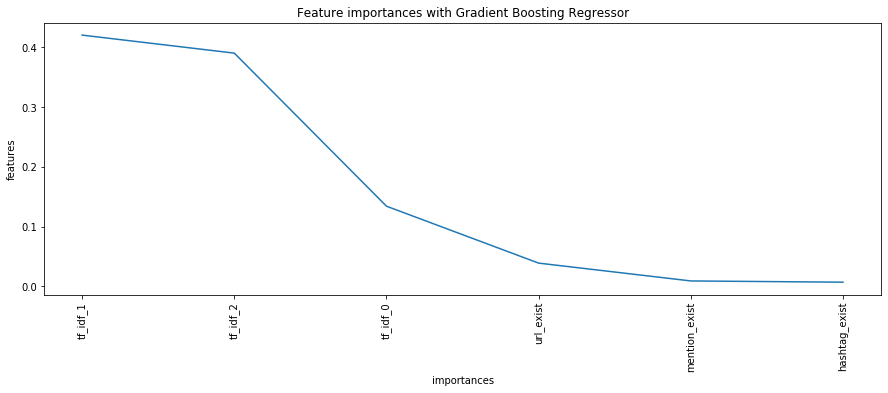

In [31]:
# features_selected = ['weekend',  'text_length', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
features_selected = ['url_exist','hashtag_exist','mention_exist', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 261.2822357089405


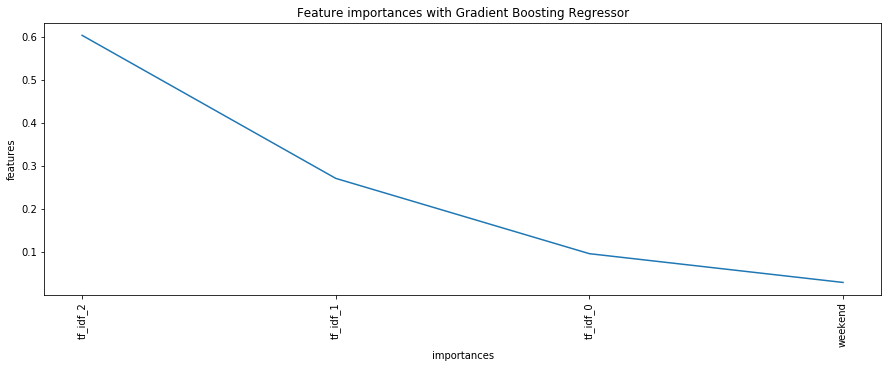

In [32]:
# features_selected = ['text_length', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
features_selected = ['weekend', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 256.0056062415042


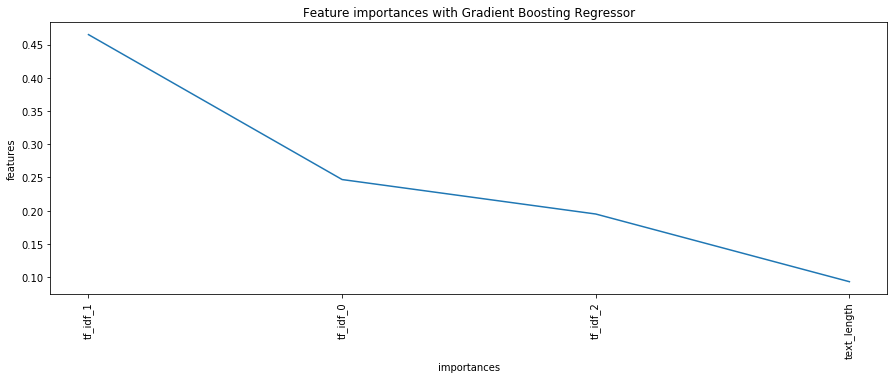

In [33]:
# features_selected = ['text_length', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
features_selected = ['text_length', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 262.47525964713947


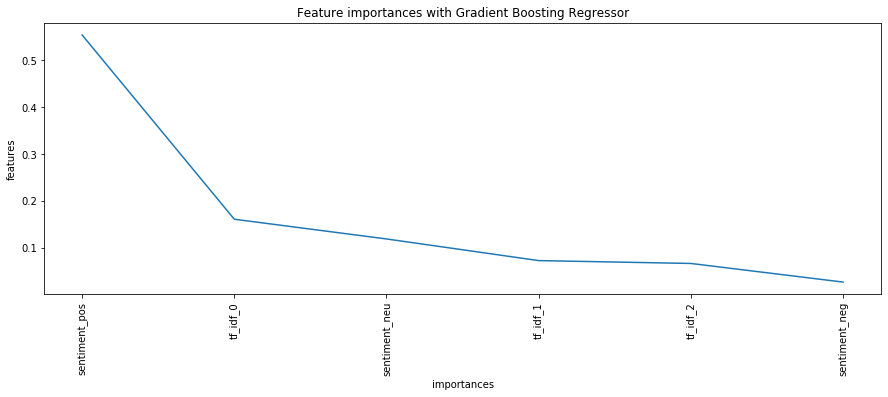

In [35]:
features_selected = ['sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 260.93256441108036


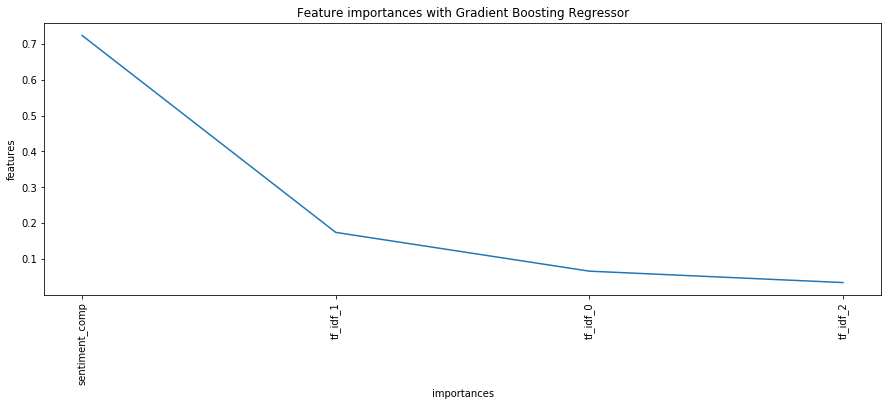

In [36]:
features_selected = ['sentiment_comp', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

Prediction error: 261.35776626635356


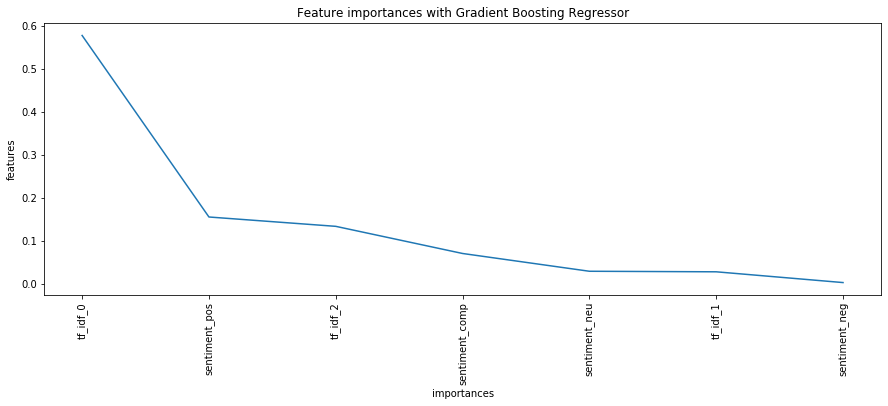

In [37]:
features_selected = ['sentiment_comp','sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'tf_idf_0', 'tf_idf_1', 'tf_idf_2']
gbr(features_selected)

## Support vector machine

In [22]:
def train_svr(features_selected):
    X_train = X_train_all[features_selected]
    X_test = X_test_all[features_selected]
    feature_map_nystroem = Nystroem()
    X_train_transformed = feature_map_nystroem.fit_transform(X_train)
    X_test_transformed = feature_map_nystroem.fit_transform(X_test)
    svr = LinearSVR()
    svr.fit(X_train_transformed, y_train)
    y_pred = svr.predict(X_test_transformed)
    print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))
    return svr

In [23]:
features_selected_base = ['tf_idf_0', 'tf_idf_1', 'tf_idf_2']
svr= train_svr(features_selected_base)

Prediction error: 78.18958728446223


In [26]:
# features_selected = ['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_exist', 'mention_count', 'url_exist', 'url_count', 'hashtag_exist', 'hashtag_count', 'timeseg', 'weekend', 'day_of_week', 'text_length', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_comp']
features_selected = ['ratio_friends_followers','tf_idf_0', 'tf_idf_1', 'tf_idf_2']
svr(features_selected)

Prediction error: 146.30842557265402


In [29]:
# features_selected = ['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_exist', 'mention_count', 'url_exist', 'url_count', 'hashtag_exist', 'hashtag_count', 'timeseg', 'weekend', 'day_of_week', 'text_length', 'sentiment_pos', 'sentiment_neg', 'sentiment_neu', 'sentiment_comp']
features_selected = ['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_exist', 'mention_count', 'url_exist', 'url_count', 'hashtag_exist', 'hashtag_count', 'weekend', 'text_length','sentiment_pos', 'sentiment_neg', 'sentiment_neu','tf_idf_0', 'tf_idf_1', 'tf_idf_2']
svr(features_selected)

Prediction error: 157.25532663406935


In [10]:
def random_forest(X_train, y_train, X_test, y_test, a, b, c):
    reg = RandomForestRegressor(n_estimators = a,   
                                max_depth    = b, 
                                random_state = c,  
                                n_jobs = -1, 
                                verbose = 5)  
    reg.fit(X_train, y_train)
    print(mean_absolute_error(y_test, np.exp( reg.predict(X_test) )-1 ) )
    return reg

In [11]:
y_train = np.log(y_train+1)

In [12]:
features_selected = ['user_verified', 'user_statuses_count', 'user_followers_count', 'user_friends_count', 'ratio_friends_followers', 'mention_exist','url_exist',  'hashtag_exist',  'weekend', 'text_length','sentiment_pos', 'sentiment_neg', 'sentiment_neu','tf_idf_0', 'tf_idf_1', 'tf_idf_2']
random_forest(X_train_all[features_selected], y_train, X_test_all[features_selected], y_test, 100, 18, 21)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   44.9s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.5min


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.7s


138.59426817371573


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=18, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=21, verbose=5, warm_start=False)

In [13]:
y_train = train_data['retweet_count']
scaler = preprocessing.StandardScaler()
scaler.fit(train_data[features_need_scaled])
X_train_final = 
X_train_final[features_need_scaled] = scaler.transform(X_train_final[features_need_scaled])
eval_data[features_need_scaled] = scaler.transform(eval_data[features_need_scaled])

eval_data=eval_data.drop(['id'],axis=1)

SyntaxError: invalid syntax (<ipython-input-13-caf5d83f26ac>, line 4)